In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sksurv.metrics import concordance_index_censored as ci_scikit
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# to change path when new data is extracted
jobid="job_202107111012220697987_homo_secureboost"  # change this to update with new output from FL model
party_A="_0_guest_1234_output_data"
party_B="_0_host_2222_output_data"
party_C="_0_host_3333_output_data"
full_path="C:/Users/chanzl_thinkpad/Dropbox/Imperial/Individual Project/NASA/survival-analysis-nasa/"
central_test_results="C:/Users/chanzl_thinkpad/Dropbox/Imperial/Individual Project/NASA/survival-analysis-nasa/graphing.csv"
filename = "data.csv"

In [2]:
df_A=pd.read_csv(os.path.join(jobid+party_A, filename))
df_B=pd.read_csv(os.path.join(jobid+party_B, filename))
df_C=pd.read_csv(os.path.join(jobid+party_C, filename))
graph_data=pd.read_csv(central_test_results)

test_clipped = pd.read_csv(full_path + 'Dataset/processed/test_clipped.csv')
train_clipped = pd.read_csv(full_path + 'Dataset/processed/train_clipped.csv')

test_trend = pd.read_csv(full_path + 'Dataset/processed/rul_FL_test_trended_cluster.csv')
train_trend = pd.read_csv(full_path + 'Dataset/processed/rul_FL_train_trended_cluster.csv')
list_results = pd.read_excel(full_path + 'results/saved_results_22-06-2021_204708.xlsx')

# Helper functions

In [3]:
def format_FL_output(df):
    df['cycle'] = 0
    df['unit num'] = 0
    df.loc[df['type'] == "train", "cycle"] = df.id % 100
    df.loc[df['type'] == "validate", "cycle"] = df.id % 100000
    
    # retrieve unit num
    df.loc[df['type'] == "train", "unit num"] = (df['id'] - df['cycle']) / 100
    df.loc[df['type'] == "validate", "unit num"] = (df['id'] - df['cycle']) / 100000
    
    df['unit num'] = df['unit num'].astype(int)
    df.rename(columns={'predict_result': 'y_hat'}, inplace=True)

In [4]:
def map_test_result(df_temp, df_main, L=20):
    interim_result = df_main.copy()
    interim_result['y_hat'] = 0
    count = 0
    for engine in interim_result['unit num'].unique():
        # get first and last index position of each set of engine
        first_idx = interim_result['unit num'].eq(engine).idxmax()
        last_idx = interim_result['unit num'].eq(engine+1).idxmax()-1
        if last_idx == -1:
            last_idx = len(interim_result)-1

        # populate RUL for middle cycles
        while (last_idx - first_idx) >= L-1:
            mid_idx = first_idx + L - 1
            interim_result.iat[mid_idx, -1] = df_temp.iloc[count]['y_hat']
            anchor_up = df_temp.iloc[count]['y_hat']
            anchor_down = df_temp.iloc[count]['y_hat']
            count += 1
            first_idx += L
            for offset in range(1, L):
                interim_result.iat[mid_idx-offset, -1] = anchor_up + 1
                anchor_up += 1

        # populate RUL for remaining cycles
        for offset in range(1, last_idx-mid_idx+1):
            interim_result.iat[mid_idx + offset, -1] = anchor_down - 1
            anchor_down -= 1

    return interim_result

In [5]:
def nasaScore(RUL_true, RUL_hat):
    d = RUL_hat - RUL_true
    score = 0
    for i in d:
        if i >= 0:
            score += np.math.exp(i / 13) - 1
        else:
            score += np.math.exp(- i / 10) - 1
    return score/len(RUL_true)  # should the score be averaged?

In [6]:
def make_graph(df, selected_unit_num):
    fig, axs = plt.subplots(int(len(selected_unit_num)/2), 2)
    models = ['RUL', 'NN (tuned)', 'RF (trended)', 'FL-GBDT (Trended)']
    i = -1
    for ax in axs.flatten():
        i += 1
        df_graph = df[df['unit num'] == selected_unit_num[i]]
        ax.set_title('Test engine ' + str(selected_unit_num[i]))
        for col in models:
            if col == 'RUL':
                ax.plot(df_graph['cycle'], df_graph[col], label=col, linestyle='dashed', linewidth=0.75)
            else:
                ax.plot(df_graph['cycle'], df_graph[col], label=col, linewidth=0.75)
    plt.xlabel('Cycles')
    plt.ylabel('RUL')
    plt.legend(fontsize=14) # using a size in points
    # plt.rcParams["figure.figsize"] = (200,30)  # width x height
    # plt.figure(figsize=(50,10))
    plt.show()

In [7]:
def evaluate(model, df_result, label='test'):
    """ Evaluates model output on rmse, R2 and C-Index
    Args:
    model (string): name of model for documentation
    df_result (pandas.df): dataframe with the headers 'unit num', 'RUL', 'y_hat', 'breakdown'
    label (string): type of output (train or test)

    Returns:
    list: returns [model, label, rmse, ci_sk, variance]
    """

    y_true = df_result['RUL']
    y_hat = df_result['y_hat']
    df_result['breakdown'].replace(0, False, inplace=True)  # rsf only takes true or false
    df_result['breakdown'].replace(1, True, inplace=True)  # rsf only takes true or false

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)

    # the concordance index (CI) is interested on the order of the predictions, not the predictions themselves
    # CI can only be measured between individual samples where a censoring or failure event occurred
    # https://medium.com/analytics-vidhya/concordance-index-72298c11eac7#:~:text=The%20concordance%20index%20or%20c,this%20definition%20mean%20in%20practice
    df_result_grouped = df_result.groupby('unit num').last()
    breakdown = df_result_grouped['breakdown']
    y_true = df_result_grouped['RUL']
    y_hat = df_result_grouped['y_hat']
    ci_sk = ci_scikit(breakdown, y_true, y_hat)[0]
    score = nasaScore(y_true, y_hat)  # score should be based on the last instance
    print('{} set RMSE:{:.2f}, Score:{:.2f}, CI(scikit):{:.4f}, R2:{:.2f}'.format(label, rmse, score, ci_sk, variance))
    result = [model, label, rmse, score, ci_sk, variance]
    return result

In [8]:
def return_final_RUL(df, column):
    # to show avg cycle at which event occurred
    final_rul = []
    for i in range(1, 101):
        df_engine = df[df['unit num'] == i]
        max_cycle = df_engine.loc[df_engine[column].idxmin()]
        final_rul.append(max_cycle[column].astype(int))
    return final_rul

# Formatting federated output

In [9]:
format_FL_output(df_A)
format_FL_output(df_B)
format_FL_output(df_C)

In [10]:
df_master_FL = df_A.copy()
df_master_FL=df_master_FL.append(df_B)
df_master_FL=df_master_FL.append(df_C)
df_master_FL.sort_values(['id'], ascending=[True], inplace=True)

In [11]:
# drop rows that are train
df_train_FL = df_master_FL[df_master_FL.type == "train"]
df_test_FL = df_master_FL[df_master_FL.type == "validate"]

# sort
df_train_FL.sort_values(['unit num', 'cycle'], ascending=[True, True], inplace=True)
df_test_FL.sort_values(['unit num', 'cycle'], ascending=[True, True], inplace=True)

# reset index
df_train_FL.reset_index(inplace=True)
df_test_FL.reset_index(inplace=True)

C:\Users\chanzl_thinkpad\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chanzl_thinkpad\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
df_test_FL.to_excel("TEST.xlsx")

# Adding back prediction back for graphing.csv

In [13]:
df_temp = test_trend.copy()
df_temp['y_hat']=df_test_FL['y_hat']
df_temp.to_excel("df_temp.xlsx")
df_result_test = map_test_result(df_temp, test_clipped)

df_temp = train_trend.copy()
df_temp['y_hat']=df_train_FL['y_hat']
df_result_train = map_test_result(df_temp, train_clipped)

graph_data['FL-GBDT (Trended)'] = df_result_test['y_hat']
graph_data.head()

,unit num,cycle,sens2,sens3,sens4,sens7,sens8,sens11,sens12,sens13,...,Cox,RF (pre-tuned),RF (tuned),RF (trended),NN (pre-tuned),NN (tuned),rsf (pre-tuned),rsf (tuned),ct (untuned),FL-GBDT (Trended)
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,...,120.857943,121.38,125.074286,128,157.13095,122.03625,150.0,150.0,150.0,145
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,...,139.630908,129.58,129.178493,127,178.54400,129.10747,150.0,150.0,150.0,144
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,...,120.944124,124.17,121.939220,126,155.95422,123.00323,150.0,150.0,150.0,143
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,...,126.057626,125.74,127.057032,125,161.69975,124.35139,150.0,150.0,150.0,142
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,...,136.883061,132.79,134.469216,124,170.09879,125.68471,150.0,150.0,150.0,141


# Plotting output

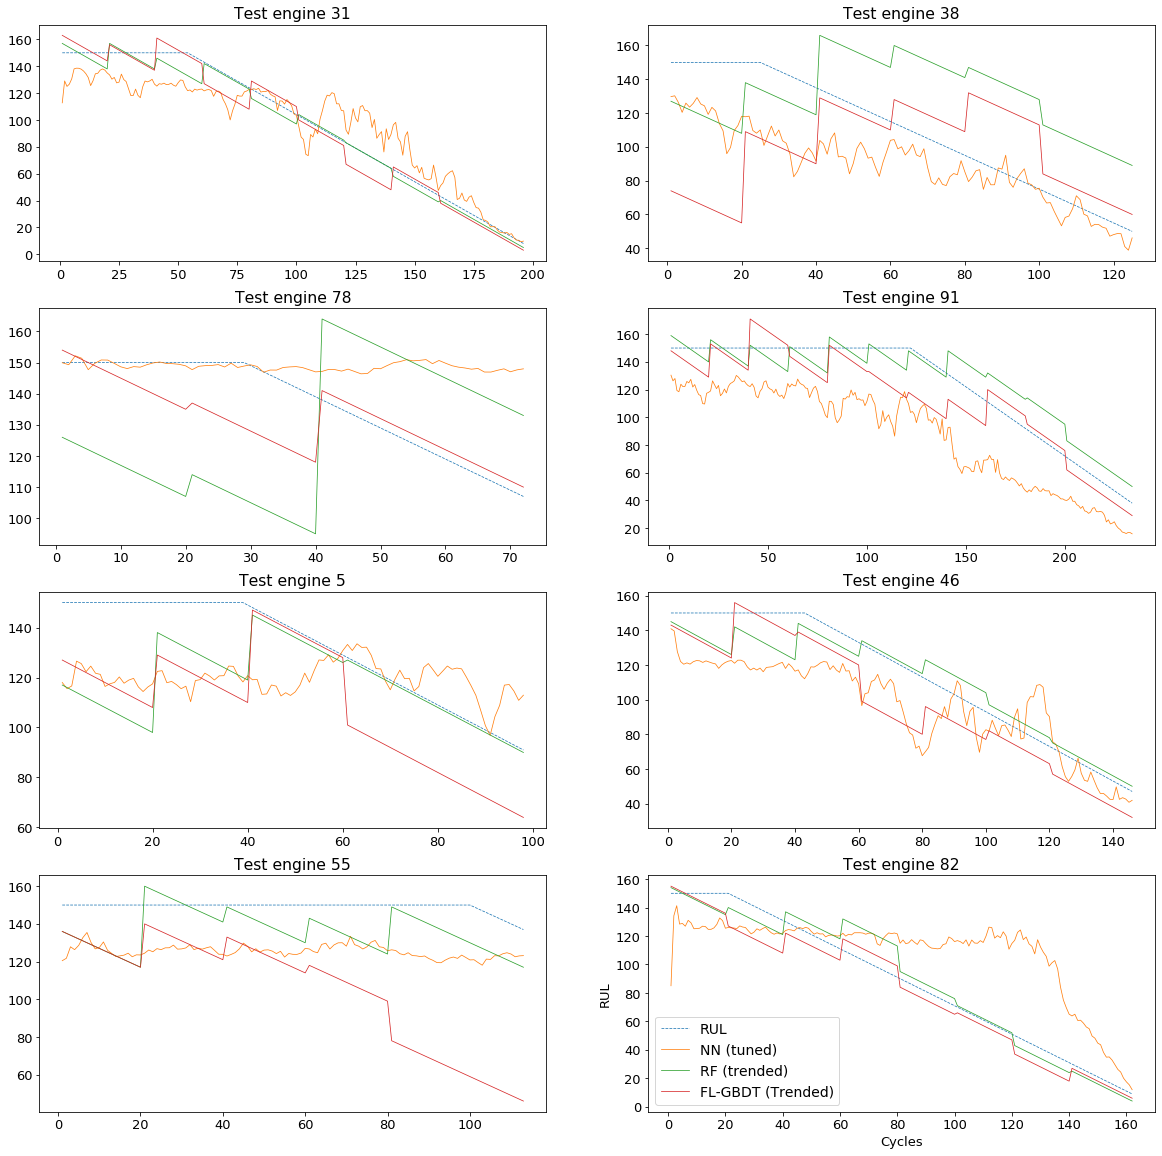

In [14]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 13})
make_graph(graph_data, [31, 38, 78, 91, 5, 46, 55, 82])

In [15]:
ori_failure = return_final_RUL(graph_data, 'RUL')
rf_failure = return_final_RUL(graph_data, 'RF (trended)')
FL_failure = return_final_RUL(graph_data, 'FL-GBDT (Trended)')

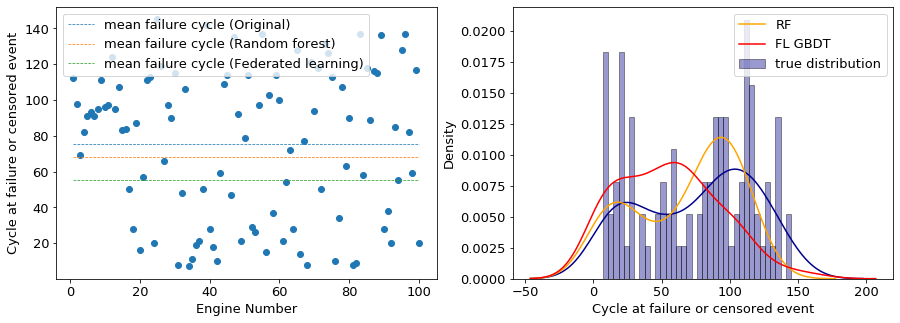

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(range(1, 101), ori_failure, marker='o')

axes[0].plot(range(1, 101), [stats.describe(ori_failure)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (Original)')
axes[0].plot(range(1, 101), [stats.describe(rf_failure)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (Random forest)')
axes[0].plot(range(1, 101), [stats.describe(FL_failure)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (Federated learning)')


axes[0].set_xlabel("Engine Number")
axes[0].set_ylabel("Cycle at failure or censored event")
axes[0].legend()

ax = sns.distplot(ori_failure, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, label="true distribution",
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax = sns.distplot(rf_failure, hist=False, kde=True, 
             bins=int(180/5), color = 'orange', 
             hist_kws={'edgecolor':'black'}, label="RF",
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax = sns.distplot(FL_failure, hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'}, label="FL GBDT",
             kde_kws={'linewidth': 1.5}, ax=axes[1])

ax.set(xlabel="Cycle at failure or censored event", ylabel='Density')
plt.show()

Text(0.5, 0, 'Remaining Useful Life (RUL) at final cycle')

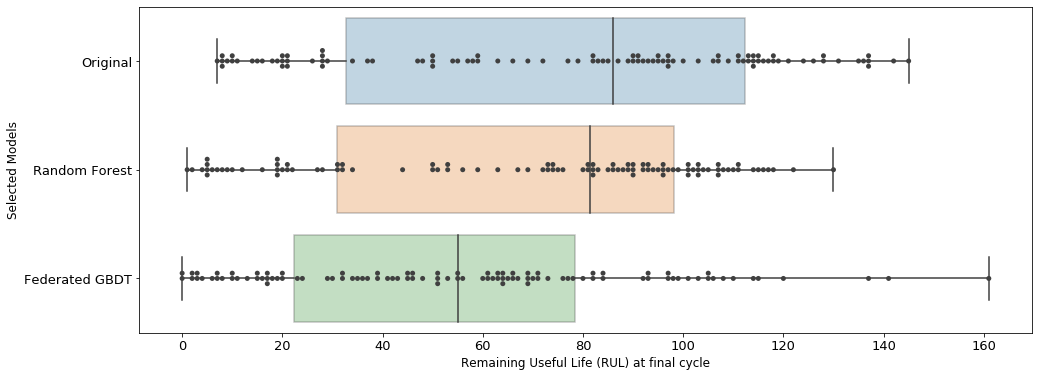

In [17]:
plt.figure(figsize=(16, 6))
dict_boxplot = {'Original': ori_failure, 'Random Forest': rf_failure, 'Federated GBDT': FL_failure} 
df_boxplot = pd.melt(pd.DataFrame(dict_boxplot))
df_boxplot.rename(columns={'variable': 'selected model', 'value': 'cycle'}, inplace=True)
ax = sns.boxplot(y="selected model", x="cycle", data=df_boxplot, boxprops=dict(alpha=.3))
ax = sns.swarmplot(y="selected model", x="cycle", data=df_boxplot, color=".25")
# ax.axes.set_title("Boxplot of RUL at final cycle - actual vs random forest vs federated model",fontsize=12)
ax.set_ylabel("Selected Models",fontsize=12)
ax.set_xlabel("Remaining Useful Life (RUL) at final cycle",fontsize=12)

# Calculating RMSE and add to total result

In [18]:
list_results.drop('timestamp', axis=1, inplace=True)

In [19]:
test_result = evaluate("FL-GBDT (Trended)", df_result_test, 'test')
test_temp = pd.DataFrame([test_result])
test_temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
test_temp.head()

test set RMSE:27.55, Score:197.34, CI(scikit):0.2017, R2:0.42


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-GBDT (Trended),test,27.545843,197.344155,0.20169,0.423795


In [20]:
train_result = evaluate("FL-GBDT (Trended)", df_result_train, 'train')
train_temp = pd.DataFrame([train_result])
train_temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
train_temp.head()

train set RMSE:5.53, Score:0.01, CI(scikit):0.0000, R2:0.99


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-GBDT (Trended),train,5.533768,0.010517,0.0,0.98651


In [21]:
list_results=list_results.append(test_temp, ignore_index=True)
list_results=list_results.append(train_temp, ignore_index=True)
list_results.sort_values(['train_test', 'RMSE'], ascending=[True, True], inplace=True)
list_results.reset_index(inplace=True, drop=True)
list_results.head(25)

,model_name,train_test,RMSE,Score,CI_SK,R2
0,RF (trended),test,16.626900,8.440800,0.16800,0.790100
1,NN (tuned),test,24.765800,10.246900,0.16470,0.534200
2,FL-GBDT (Trended),test,27.545843,197.344155,0.20169,0.423795
3,RF (pre-tuned),test,27.576600,8.480900,0.17420,0.422500
4,RF (tuned),test,27.804400,9.701800,0.18810,0.412900
5,Cox,test,31.807600,15.398300,0.18670,0.231700
6,rsf (pre-tuned),test,33.832200,13744.516700,0.29010,0.130800
7,rsf (tuned),test,34.131700,15500.418100,0.29920,0.115300
8,KM_rmst,test,34.296300,4058.178300,0.28340,0.106800
9,NN (pre-tuned),test,38.224300,132.847100,0.19320,-0.109500
